In [1]:
from salad.detection import detect
import lsst.daf.butler as dafButler
import matplotlib.pyplot as plt
import astropy.table
from joblib import delayed, Parallel

In [2]:
butler = dafButler.Butler("../data")

In [81]:
def get_patches(visits):
    return list(set(butler.registry.queryDimensionRecords(
        "patch", where="skymap='discrete' and instrument='DECam' and visit IN (" + ",".join(map(str, visits)) + ")"
    )))

def get_visit_numbers(refs):
    return list(set([ref.dataId['visit'] for ref in refs]))


def get_visits(visits):
    return list(set(butler.registry.queryDimensionRecords(
        "visit", where="skymap='discrete' and instrument='DECam' and visit IN (" + ",".join(map(str, visits)) + ")"
    )))

In [149]:
all_refs = list(set(list(butler.registry.queryDatasets(
    "differenceExp",
    collections="DEEP/20190403/A0c",
))))
visit_nums = get_visit_numbers(all_refs)
patches = get_patches(visit_nums)
patches = {p.id : p for p in patches}
visits = get_visits(visit_nums)
visits = {v.id : v for v in visits}
len(patches), len(visits)

(187, 104)

In [150]:
len(all_refs)

6240

In [117]:
patch_refs = dict()
for patch in patches:
    patch_refs[patch] = list(set(list(butler.registry.queryDatasets(
        "differenceExp",
        collections="DEEP/20190403/A0c",
        where=f"instrument='DECam' and skymap='discrete' and patch={patch} and visit IN (" + ",".join(map(str, visit_nums)) + ")", 
    ))))


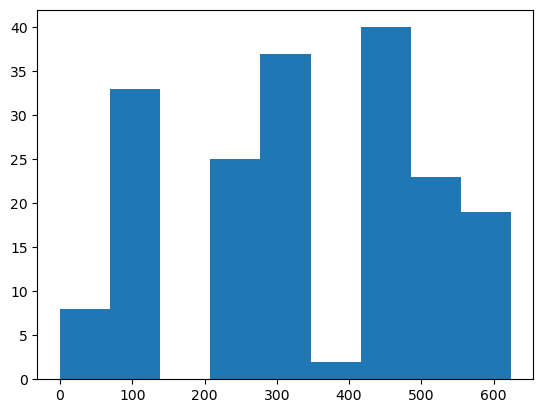

In [118]:
inputs = []
for patch in patch_refs:
    inputs.append(len(patch_refs[patch]))
    
plt.hist(inputs, bins='auto')
plt.show()

In [136]:
set(inputs)

{0, 104, 208, 286, 312, 353, 390, 416, 520, 624}

In [137]:
list(filter(lambda x : len(patch_refs[x]) == 104, patch_refs.keys()))

[17156,
 62226,
 61524,
 59428,
 17505,
 59430,
 60125,
 60134,
 59432,
 15057,
 14355,
 14001,
 61185,
 14003,
 62582,
 17850,
 60824,
 17852,
 17854,
 61884,
 16807,
 14000,
 59427,
 14002,
 60485,
 59783,
 59429,
 14706,
 62928,
 14004,
 17851,
 59776,
 17853]

In [138]:
max_patch_idx = 17156
max_patch = patches[max_patch_idx]

In [139]:
len(patch_refs[max_patch_idx]) / 104

1.0

In [140]:
patch_refs[max_patch_idx][0].dataId['detector'], patch_refs[max_patch_idx][0].dataId['visit']

(8, 845932)

In [146]:
def get_vdr(refs):
    _where = []
    for ref in refs:
        _where.append(f"(visit={ref.dataId['visit']} AND detector={ref.dataId['detector']})")
    where = "instrument='DECam' and (" + " OR ".join(_where) + ")"
#     print(where)
    return list(butler.registry.queryDimensionRecords("visit_detector_region", where=where))
    
# vdrs = get_vdr(patch_refs[max_patch_idx])

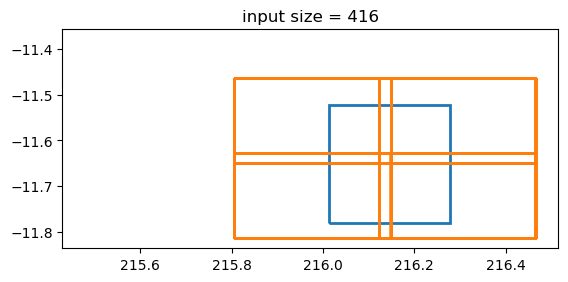

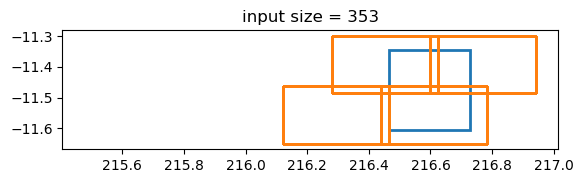

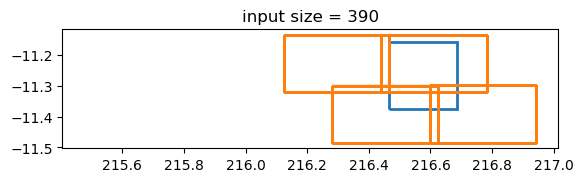

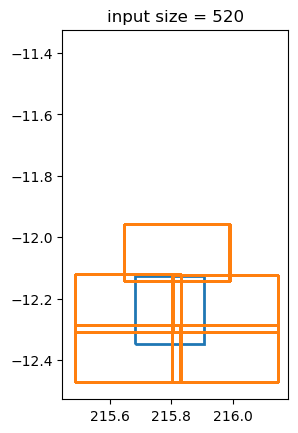

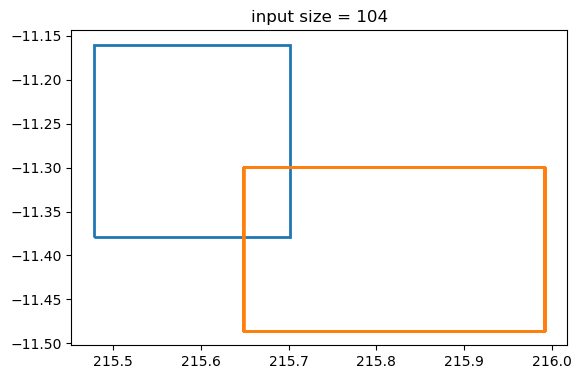

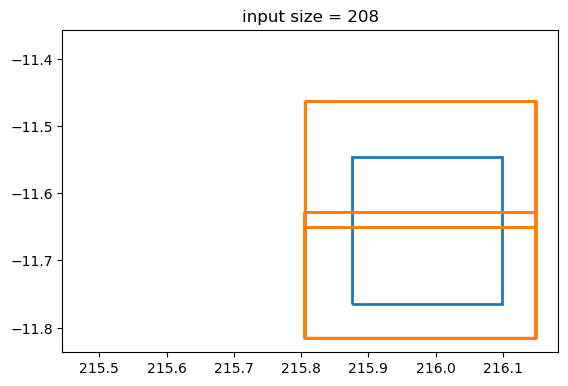

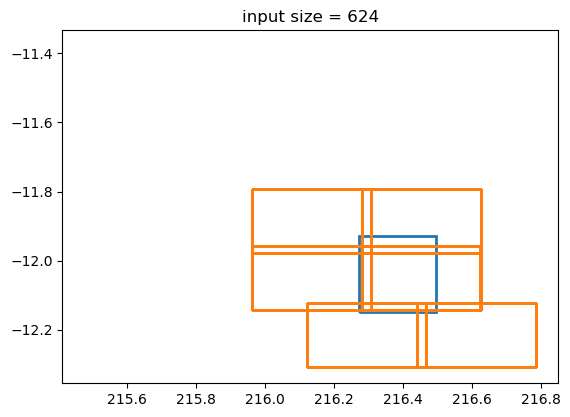

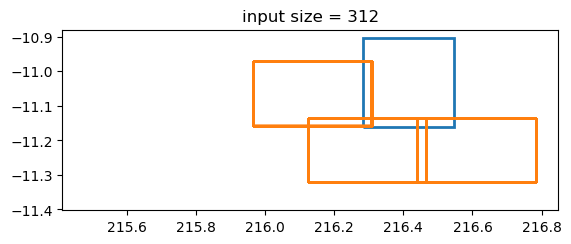

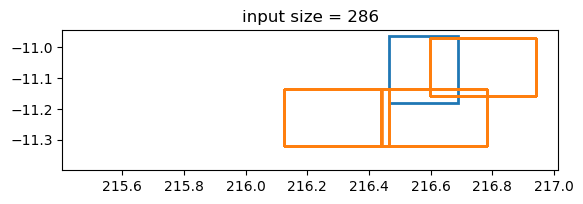

In [155]:
from matplotlib.path import Path
from matplotlib.patches import PathPatch

def corners(region):
    bbox = region.getBoundingBox()
    lat = bbox.getLat()
    lon = bbox.getLon()
    return [
        (lon.getA().asDegrees(), lat.getA().asDegrees()),
        (lon.getA().asDegrees(), lat.getB().asDegrees()),
        (lon.getB().asDegrees(), lat.getB().asDegrees()),
        (lon.getB().asDegrees(), lat.getA().asDegrees()),
    ]

def rect(region, **kwargs):
    from matplotlib.patches import Rectangle
    c = corners(region)
    return PathPatch(Path(c + [c[0]]), **kwargs)


def plot_patch_and_detectors(patch_idx):
    patch = patches[patch_idx]
    vdrs = get_vdr(patch_refs[patch_idx])
    
    fig = plt.figure()
    ax = plt.subplot()
    ax.set_aspect('equal')
    ax.add_patch(rect(patch.region, linewidth=2, edgecolor='C0', fill=False))
    c = corners(max_patch.region)
    plt.scatter(*c[0], s=0)

    for vdr in vdrs:
        ax.add_patch(rect(vdr.region, linewidth=1, edgecolor='C1', fill=False))
        c = corners(vdr.region)
        plt.scatter(*c[0], s=0)

    plt.title(f"input size = {input_size}")
    plt.show()
    

for input_size in set(inputs):
    if input_size == 0:
        continue
    
    patch_idx = list(filter(lambda x : len(patch_refs[x]) == input_size, patch_refs.keys()))[0]
    plot_patch_and_detectors(patch_idx)
    

In [157]:
# Really, I want to perform detection on a data subset, push that into a database, and then query RA/Dec ranges from a database
# Well, RA/Dec ranges are the patches so that's fine
# data subset == long stare
# or data subset == one patch
# but really, detection should be cached on a per-detector basis and can be a lookup into the butler

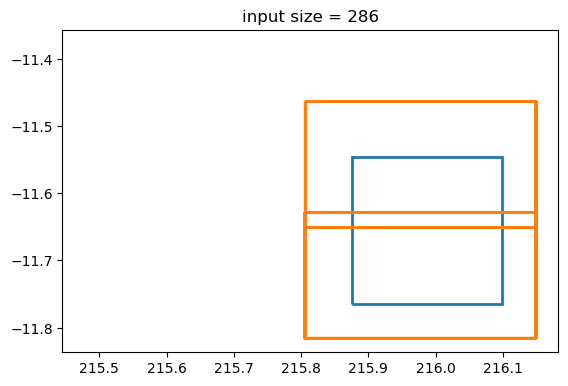

In [156]:
patch_idx = list(filter(lambda x : len(patch_refs[x]) == 208, patch_refs.keys()))[0]
patch = patches[patch_idx]
plot_patch_and_detectors(patch_idx)

In [164]:
detector_refs = list(set(list(butler.registry.queryDatasets(
    "differenceExp",
    collections="DEEP/20190403/A0c",
    where="instrument='DECam' and detector=5",
))))

def detect_ref(ref):
    return detect(butler.get(ref), threshold=3)

detect_results = Parallel(n_jobs=48)(delayed(detect_ref)(ref) for ref in detector_refs)

In [16]:
from matplotlib import colormaps
# print(list(colormaps))

['magma', 'inferno', 'plasma', 'viridis', 'cividis', 'twilight', 'twilight_shifted', 'turbo', 'Blues', 'BrBG', 'BuGn', 'BuPu', 'CMRmap', 'GnBu', 'Greens', 'Greys', 'OrRd', 'Oranges', 'PRGn', 'PiYG', 'PuBu', 'PuBuGn', 'PuOr', 'PuRd', 'Purples', 'RdBu', 'RdGy', 'RdPu', 'RdYlBu', 'RdYlGn', 'Reds', 'Spectral', 'Wistia', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd', 'afmhot', 'autumn', 'binary', 'bone', 'brg', 'bwr', 'cool', 'coolwarm', 'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_gray', 'gist_heat', 'gist_ncar', 'gist_rainbow', 'gist_stern', 'gist_yarg', 'gnuplot', 'gnuplot2', 'gray', 'hot', 'hsv', 'jet', 'nipy_spectral', 'ocean', 'pink', 'prism', 'rainbow', 'seismic', 'spring', 'summer', 'terrain', 'winter', 'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c', 'grey', 'gist_grey', 'gist_yerg', 'Grays', 'magma_r', 'inferno_r', 'plasma_r', 'viridis_r', 'cividis_r', 'twilight_r', 'twilight_shifted_r', 'turbo_r', 'Blues_r', 'BrBG_r', '

In [167]:
import pickle

run: 2.4038186073303223
astropy: 2.6037020683288574
ra/dec: 0.07148981094360352
run: 2.1092417240142822
astropy: 1.9165561199188232
ra/dec: 0.031378984451293945
run: 2.232140064239502
astropy: 0.6017575263977051
ra/dec: 0.021808147430419922
run: 2.0353052616119385
astropy: 1.0600905418395996
ra/dec: 0.023088693618774414
run: 2.1667470932006836
astropy: 1.5097932815551758
ra/dec: 0.02903008460998535
run: 2.5765271186828613
astropy: 1.227797508239746
ra/dec: 0.023405790328979492
run: 2.96055006980896
astropy: 1.833996057510376
ra/dec: 0.052161455154418945
run: 1.918358325958252
astropy: 1.0953338146209717
ra/dec: 0.03269171714782715
run: 1.8290495872497559
astropy: 1.5136709213256836
ra/dec: 0.035547733306884766
run: 1.9268097877502441
astropy: 1.4808809757232666
ra/dec: 0.02962517738342285
run: 1.8146662712097168
astropy: 1.016319990158081
ra/dec: 0.02287745475769043
run: 2.4320385456085205
astropy: 1.2809689044952393
ra/dec: 0.024131298065185547
run: 2.0771193504333496
astropy: 0.96252

run: 2.3409221172332764
astropy: 0.8180325031280518
ra/dec: 0.0171663761138916
run: 2.017155885696411
astropy: 0.7942502498626709
ra/dec: 0.03084540367126465
run: 1.822446346282959
astropy: 1.2913997173309326
ra/dec: 0.023659944534301758
run: 2.051578998565674
astropy: 0.8729965686798096
ra/dec: 0.022925376892089844
run: 1.980900526046753
astropy: 1.2454040050506592
ra/dec: 0.03431439399719238
run: 2.1413609981536865
astropy: 1.6025941371917725
ra/dec: 0.03560042381286621
run: 1.943284034729004
astropy: 1.1659319400787354
ra/dec: 0.021856307983398438
run: 3.0183184146881104
astropy: 1.3948147296905518
ra/dec: 0.025606155395507812
run: 3.2835004329681396
astropy: 1.506148338317871
ra/dec: 0.03982877731323242
run: 2.0938966274261475
astropy: 1.55859375
ra/dec: 0.03038167953491211
run: 2.0817136764526367
astropy: 1.3611969947814941
ra/dec: 0.023979902267456055
run: 2.3091886043548584
astropy: 2.188856840133667
ra/dec: 0.032431602478027344
run: 2.2315053939819336
astropy: 1.175006628036499

run: 2.4965779781341553
astropy: 2.781790018081665
ra/dec: 0.05019092559814453
run: 2.3051302433013916
astropy: 0.9611790180206299
ra/dec: 0.023771047592163086
run: 2.3154616355895996
astropy: 1.1923437118530273
ra/dec: 0.036174774169921875
run: 1.929908037185669
astropy: 1.2759768962860107
ra/dec: 0.025667905807495117
run: 2.1426913738250732
astropy: 1.8074512481689453
ra/dec: 0.10448384284973145
run: 2.434906005859375
astropy: 1.5897221565246582
ra/dec: 0.045182228088378906
run: 2.729710340499878
astropy: 1.4115490913391113
ra/dec: 0.03304100036621094
run: 2.3953211307525635
astropy: 1.7107477188110352
ra/dec: 0.027384042739868164
run: 2.5320606231689453
astropy: 1.7433643341064453
ra/dec: 0.026485204696655273
run: 2.103576421737671
astropy: 1.4107697010040283
ra/dec: 0.02414846420288086
run: 2.548741579055786
astropy: 1.7690699100494385
ra/dec: 0.02823042869567871
run: 2.3469204902648926
astropy: 1.4076859951019287
ra/dec: 0.01978302001953125
run: 2.7196669578552246
astropy: 1.88312

In [202]:
class DetectionCatalog():
    def __init__(self, catalog : astropy.table.Table, time: astropy.time.Time):
        self.catalog = catalog
        self.time = time

    def __reduce__(self):
        return type(self), (
            self.catalog,
            self.time
        )

class MultiEpochDetectionCatalog():
    def __init__(self, single_epoch_catalogs):
        self.single_epoch_catalogs = single_epoch_catalogs

    @property
    def time(self):
        return np.array([c.time for c in self.single_epoch_catalogs])

    @property
    def ra(self):
        return np.hstack([c.catalog["ra"] for c in self.single_epoch_catalogs])
    
    @property
    def dec(self):
        return np.hstack([c.catalog["dec"] for c in self.single_epoch_catalogs])
    
    @property
    def X(self):
        x1 = []
        x2 = []
        x3 = []
        for c in self.single_epoch_catalogs:
            ra = c.catalog['ra'].data
            dec = c.catalog['dec'].data
            t = np.array([c.time] * len(ra))
            x1.append(ra)
            x2.append(dec)
            x3.append(t)

        x1 = np.hstack(x1)
        x2 = np.hstack(x2)
        x3 = np.hstack(x3)
        return np.array([x1, x2, x3]).T

    def __reduce__(self):
        return type(self), (
            self.single_epoch_catalogs,
        )
    

c = MultiEpochDetectionCatalog([DetectionCatalog(catalog, jd) for catalog, jd in detect_results])
x = c.X

In [205]:
DetectionCatalog(catalog, jd).catalog['ra']

3.7724439687955464
3.7724541469431596
3.772480123299936
3.7724867718354744
3.7724983704328605
3.772464546351033
3.772496779063739
3.7725251803561637
3.7725018550971616
3.7725139771356564
3.7725306083293053


In [201]:
with open("test_catalog.pkl", "wb") as fd:
    pickle.dump(c, fd)

In [198]:
with open("test_catalog.pkl", "rb") as fd:
    c2 = pickle.load(fd)

In [199]:
c2

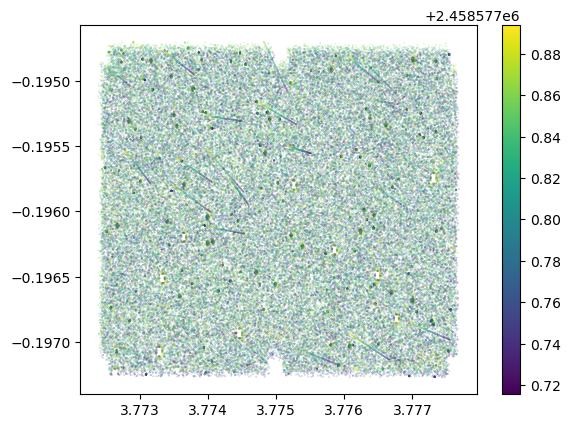

In [192]:
plt.scatter(x[:, 0], x[:, 1], c=x[:, 2], s=0.01)
plt.colorbar()
plt.show()

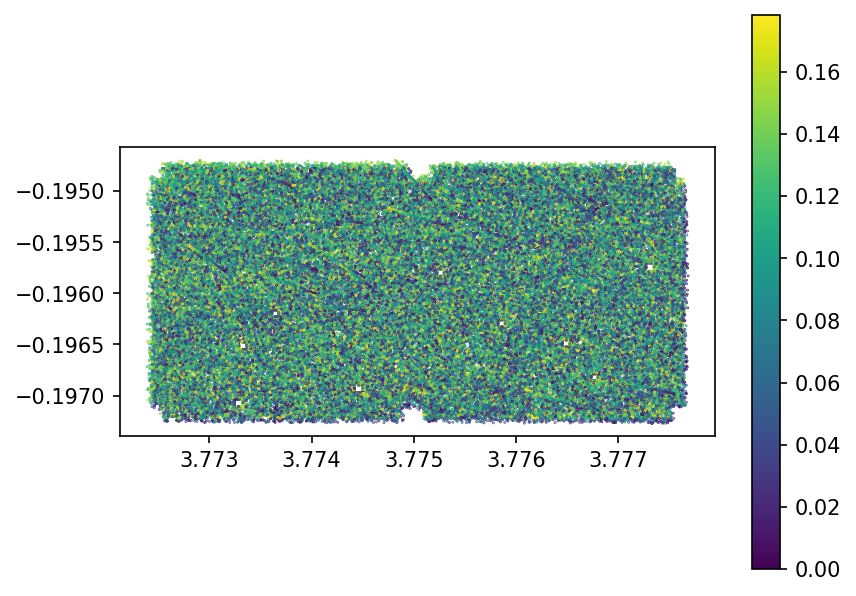

In [166]:
import matplotlib
import matplotlib.cm as cm

times = [x[1] for x in detect_results]

norm = matplotlib.colors.Normalize(vmin=0, vmax=max(times) - min(times), clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.viridis)

fig = plt.figure(dpi=150)
ax = fig.subplots()
ax.set_aspect("equal")
for catalog, jd in detect_results:
    plt.scatter(catalog['ra'], catalog['dec'], c=[mapper.to_rgba(jd  - min(times))]*len(catalog), s=0.1)

cbar = fig.colorbar(mappable=mapper, ax=ax)
plt.show()

In [19]:
catalogs = []
times = []
for ref in refs[0:2]:
    catalog, jd = detect(butler.get(ref))
    catalogs.append(catalog)
    times.append(jd)

detections = astropy.table.vstack(catalogs)

run: 1.9636218547821045
astropy: 1.0434670448303223
ra/dec: 0.023771286010742188
run: 1.6856977939605713
astropy: 1.464385747909546
ra/dec: 0.033210039138793945


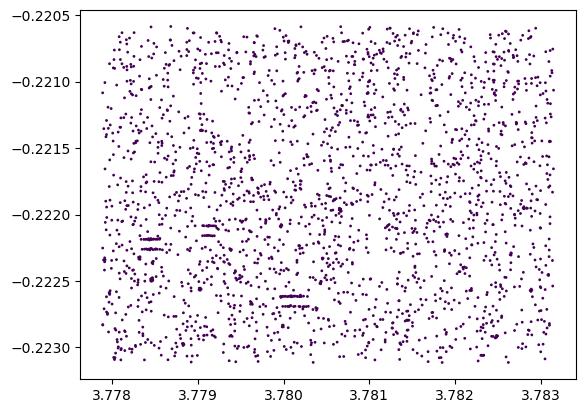

In [18]:
catalog['ra']

3.7779115381521957